# Linear Regression Challenge

We begin by investigating the data on how the categories of different criminal activities may be related to each other.  Data will be cleaned and examined as we go along.  Then, PCA will be applied.  After which we can use Holdout Groups and Cross Validation to examine the accuracy of the data.

Using this data, build a regression model to predict property crimes. You can use the features you prepared in the previous assignment, new features of your own choosing, or a combination. The goal here is prediction rather than understanding mechanisms, so the focus is on creating a model that explains a lot of variance.

In [440]:
# The objective is to make the equation equivalent to Propertycrime=α+Population+Population2+Murder+Robbery

import math
import warnings
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
from IPython.display import display
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:3f}'.format

# Suppress warnings
import warnings
warnings.filterwarnings(action='ignore', module='scipy', message='^internal gelsd')

# Bring in data
df = pd.read_csv("table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.csv")
# Pick the fourth row as the header
df.columns = df.iloc[3]
# Rename column headers to make it easier to work with
df.columns = ['city', 'population', 'violent', 'murder', 'rape_1', 'rape_2', 'robbery', 'assault', 'property', 'burglary', 'larceny', 'motor', 'arson', 'empty']
# Remove the any lines that are empty in Population column.
df.dropna(subset=['population'], inplace=True)
# Remove another line filled with wrong data
df.drop(df.index[0], inplace=True)
# Remove NaN values
df = df.fillna(0)

df.head()

,city,population,violent,murder,rape_1,rape_2,robbery,assault,property,burglary,larceny,motor,arson,empty
4,Adams Village,"1,861",0,0,0,0,0,0,12,2,10,0,0,0.000000
5,Addison Town and Village,"2,577",3,0,0,0,0,3,24,3,20,1,0,0.000000
6,Akron Village,"2,846",3,0,0,0,0,3,16,1,15,0,0,0.000000
7,Albany,"97,956",791,8,0,30,227,526,"4,090",705,"3,243",142,0,0.000000
8,Albion Village,"6,388",23,0,0,3,4,16,223,53,165,5,0,0.000000


# PCA Univariate Method

In [441]:
# Remove columns that will not be added to the equation.
#df = df.drop(columns=['city', 'violent', 'rape_1', 'rape_2', 'property', 'burglary', 'larceny', 'motor', 'arson', 'empty'])
df = df.drop(columns=['city', 'population', 'rape_1', 'empty'])
# Make definition to remove commas from strings
def replace(column):
    df[column] = df[column].str.replace(',', '')
    
#replace('population')
replace('violent')
replace('murder')
replace('rape_2')
replace('robbery')
replace('assault')
replace('property')
replace('burglary')
replace('larceny')
replace('motor')

# Convert type to integers
df.head()

,violent,murder,rape_2,robbery,assault,property,burglary,larceny,motor,arson
4,0,0,0,0,0,12,2,10,0,0
5,3,0,0,0,3,24,3,20,1,0
6,3,0,0,0,3,16,1,15,0,0
7,791,8,30,227,526,4090,705,3243,142,0
8,23,0,3,4,16,223,53,165,5,0


In [442]:
# Convert to integer
#df.population = df.population.astype(int)
df.violent = df.violent.astype(int)
df.murder = df.murder.astype(int)
df.rape_2 = df.rape_2.astype(int)
df.robbery = df.robbery.astype(int)
df.assault = df.assault.astype(int)
df.property = df.property.astype(int)
df.burglary = df.burglary.astype(int)
df.larceny = df.larceny.astype(int)
df.motor = df.motor.astype(int)
df.arson = df.arson.astype(int)

df.head()

,violent,murder,rape_2,robbery,assault,property,burglary,larceny,motor,arson
4,0,0,0,0,0,12,2,10,0,0
5,3,0,0,0,3,24,3,20,1,0
6,3,0,0,0,3,16,1,15,0,0
7,791,8,30,227,526,4090,705,3243,142,0
8,23,0,3,4,16,223,53,165,5,0


In [443]:
df.describe() # Make a summary of important data

,violent,murder,rape_2,robbery,assault,property,burglary,larceny,motor,arson
count,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,201.594828,1.566092,5.864943,72.902299,121.261494,792.606322,119.683908,637.017241,35.905172,1.005747
std,2815.268504,18.303673,60.425452,1031.032873,1706.131730,7659.724746,924.948789,6346.054451,403.423826,7.884612
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,1.000000,40.500000,6.000000,31.000000,0.000000,0.000000
50%,6.000000,0.000000,0.000000,1.000000,4.000000,112.500000,17.500000,94.000000,2.000000,0.000000
75%,22.000000,0.000000,2.000000,5.000000,14.000000,341.000000,51.250000,287.250000,7.000000,0.000000
max,52384.000000,335.000000,1112.000000,19170.000000,31767.000000,141971.000000,16606.000000,117931.000000,7434.000000,132.000000


In [444]:
df.var() # Return unbiased variance over requested axis

violent     7925736.748907
murder          335.024438
rape_2         3651.235309
robbery     1063028.785816
assault     2910885.478974
property   58671383.178865
burglary     855530.262910
larceny    40272407.089039
motor        162750.783489
arson            62.167114
dtype: float64

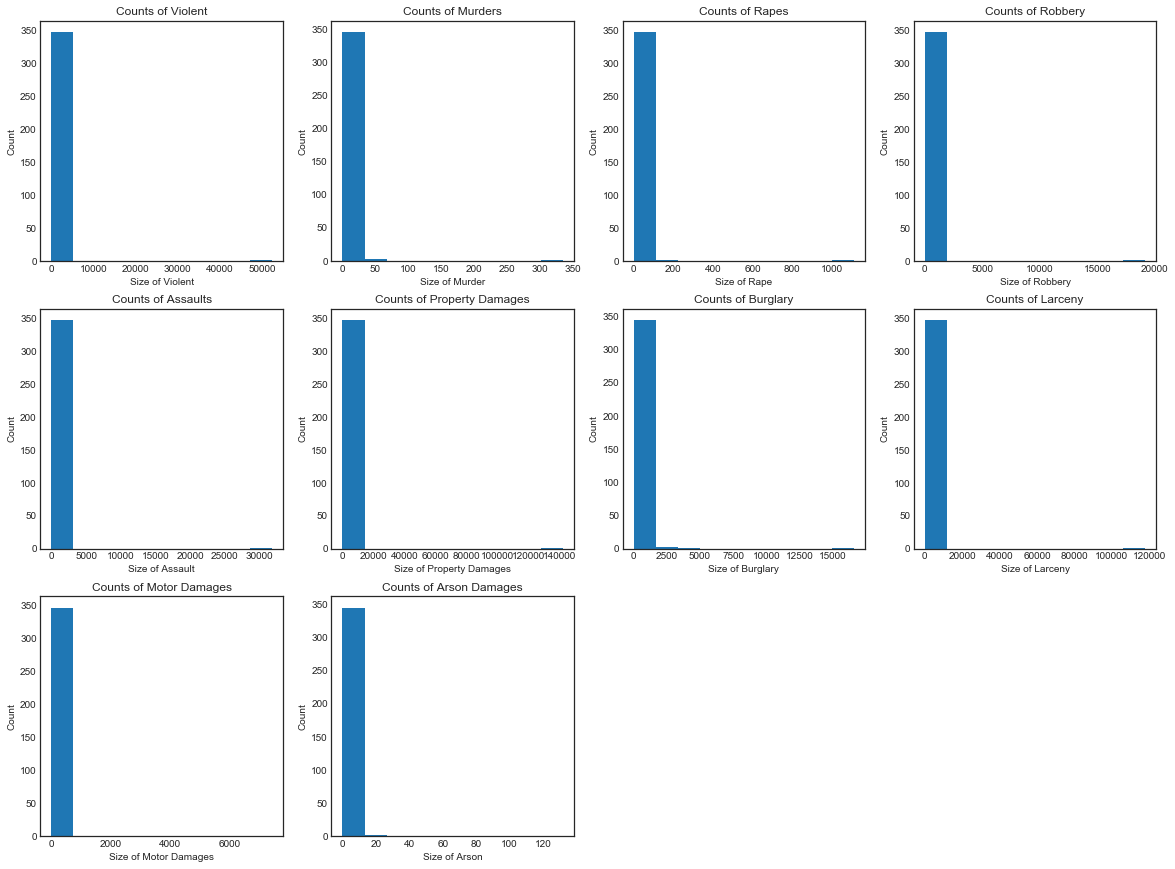

In [445]:
# Plot some comparisons so we know the distribution
plt.figure(figsize=(20, 15))

plt.subplot(3, 4, 1)
plt.hist(df.violent)
plt.ylabel('Count')
plt.xlabel('Size of Violent')
plt.title('Counts of Violent')

plt.subplot(3, 4, 2)
plt.hist(df.murder)
plt.ylabel('Count')
plt.xlabel('Size of Murder')
plt.title('Counts of Murders')

plt.subplot(3, 4, 3)
plt.hist(df.rape_2)
plt.ylabel('Count')
plt.xlabel('Size of Rape')
plt.title('Counts of Rapes')

plt.subplot(3, 4, 4)
plt.hist(df.robbery)
plt.ylabel('Count')
plt.xlabel('Size of Robbery')
plt.title('Counts of Robbery')

plt.subplot(3, 4, 5)
plt.hist(df.assault)
plt.ylabel('Count')
plt.xlabel('Size of Assault')
plt.title('Counts of Assaults')

plt.subplot(3, 4, 6)
plt.hist(df.property)
plt.ylabel('Count')
plt.xlabel('Size of Property Damages')
plt.title('Counts of Property Damages')

plt.subplot(3, 4, 7)
plt.hist(df.burglary)
plt.ylabel('Count')
plt.xlabel('Size of Burglary')
plt.title('Counts of Burglary')

plt.subplot(3, 4, 8)
plt.hist(df.larceny)
plt.ylabel('Count')
plt.xlabel('Size of Larceny')
plt.title('Counts of Larceny')

plt.subplot(3, 4, 9)
plt.hist(df.motor)
plt.ylabel('Count')
plt.xlabel('Size of Motor Damages')
plt.title('Counts of Motor Damages')

plt.subplot(3, 4, 10)
plt.hist(df.arson)
plt.ylabel('Count')
plt.xlabel('Size of Arson')
plt.title('Counts of Arson Damages')

plt.show()

In [446]:
# We notice that the last three cells showed some serious outliers
df = df.sort_values('property')
df.tail(10)

,violent,murder,rape_2,robbery,assault,property,burglary,larceny,motor,arson
350,1036,6,25,390,615,2368,470,1662,236,10
325,361,7,27,102,225,2528,449,1997,82,0
57,158,0,11,48,99,2689,345,2271,73,2
289,607,8,31,203,365,2800,769,1878,153,0
222,584,3,12,166,403,2807,746,1949,112,22
7,791,8,30,227,526,4090,705,3243,142,0
314,1192,21,75,400,696,6473,1781,4298,394,57
276,2107,42,92,918,1055,10051,2587,6855,609,132
39,3249,47,145,1322,1735,12491,3458,8076,957,0
220,52384,335,1112,19170,31767,141971,16606,117931,7434,0


Removed the murder, robbery, and assault because values are far too low to fit with the rest.  This also happened to relatively fit the multivariable regression equation that we will need to work with later.  

The equation is: Property crime = alpha + population + population^2 + murder + robbery

In [447]:
# Remove the outliers with extreme value (anything in the extreme thousands)
df.drop(df.index[-5:], inplace=True)
df.tail(10)

,violent,murder,rape_2,robbery,assault,property,burglary,larceny,motor,arson
319,371,1,14,145,211,1985,593,1305,87,5
66,63,0,0,31,32,1990,186,1753,51,10
11,107,1,7,31,68,2118,204,1882,32,3
130,151,0,9,60,82,2303,332,1925,46,0
26,284,3,19,101,161,2349,525,1767,57,0
350,1036,6,25,390,615,2368,470,1662,236,10
325,361,7,27,102,225,2528,449,1997,82,0
57,158,0,11,48,99,2689,345,2271,73,2
289,607,8,31,203,365,2800,769,1878,153,0
222,584,3,12,166,403,2807,746,1949,112,22


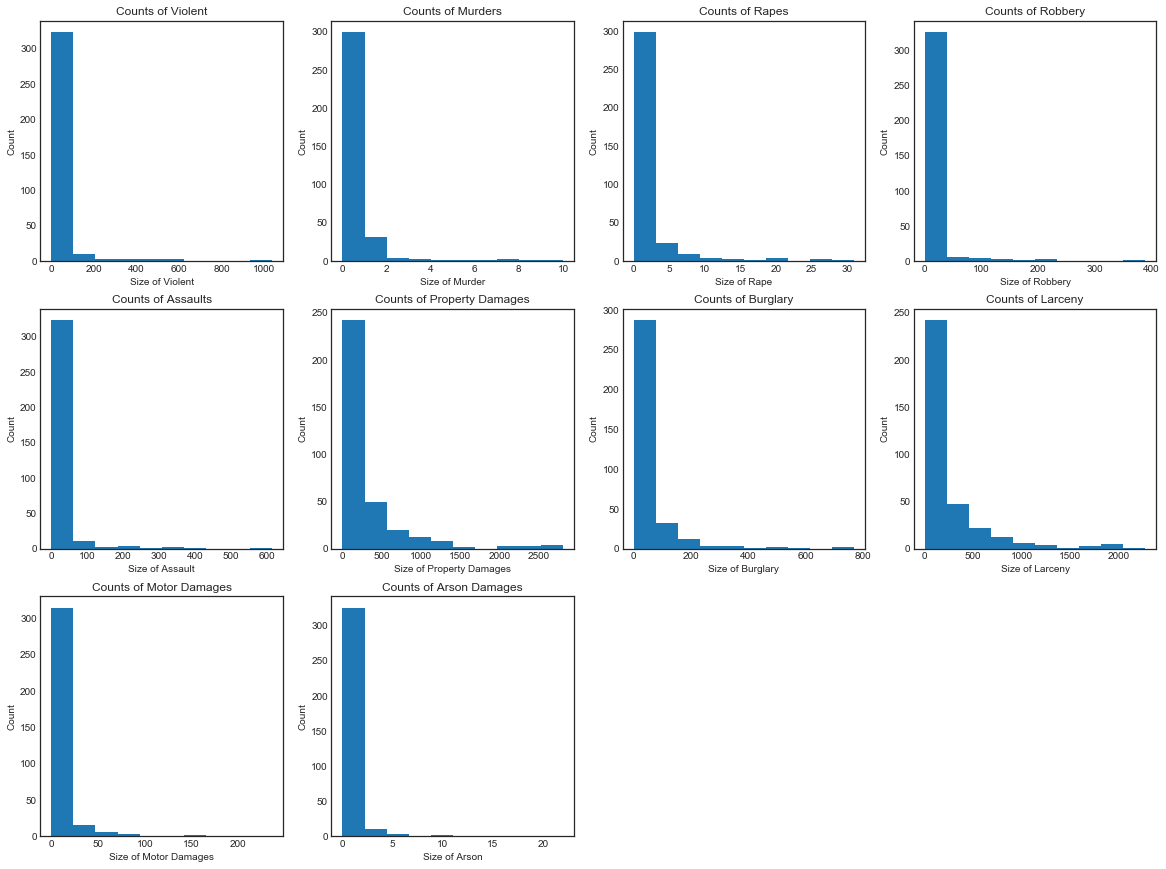

In [448]:
# Plot some comparisons so we know the distribution
plt.figure(figsize=(20, 15))

plt.subplot(3, 4, 1)
plt.hist(df.violent)
plt.ylabel('Count')
plt.xlabel('Size of Violent')
plt.title('Counts of Violent')

plt.subplot(3, 4, 2)
plt.hist(df.murder)
plt.ylabel('Count')
plt.xlabel('Size of Murder')
plt.title('Counts of Murders')

plt.subplot(3, 4, 3)
plt.hist(df.rape_2)
plt.ylabel('Count')
plt.xlabel('Size of Rape')
plt.title('Counts of Rapes')

plt.subplot(3, 4, 4)
plt.hist(df.robbery)
plt.ylabel('Count')
plt.xlabel('Size of Robbery')
plt.title('Counts of Robbery')

plt.subplot(3, 4, 5)
plt.hist(df.assault)
plt.ylabel('Count')
plt.xlabel('Size of Assault')
plt.title('Counts of Assaults')

plt.subplot(3, 4, 6)
plt.hist(df.property)
plt.ylabel('Count')
plt.xlabel('Size of Property Damages')
plt.title('Counts of Property Damages')

plt.subplot(3, 4, 7)
plt.hist(df.burglary)
plt.ylabel('Count')
plt.xlabel('Size of Burglary')
plt.title('Counts of Burglary')

plt.subplot(3, 4, 8)
plt.hist(df.larceny)
plt.ylabel('Count')
plt.xlabel('Size of Larceny')
plt.title('Counts of Larceny')

plt.subplot(3, 4, 9)
plt.hist(df.motor)
plt.ylabel('Count')
plt.xlabel('Size of Motor Damages')
plt.title('Counts of Motor Damages')

plt.subplot(3, 4, 10)
plt.hist(df.arson)
plt.ylabel('Count')
plt.xlabel('Size of Arson')
plt.title('Counts of Arson Damages')

plt.show()

# PCA Bivariate Method

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


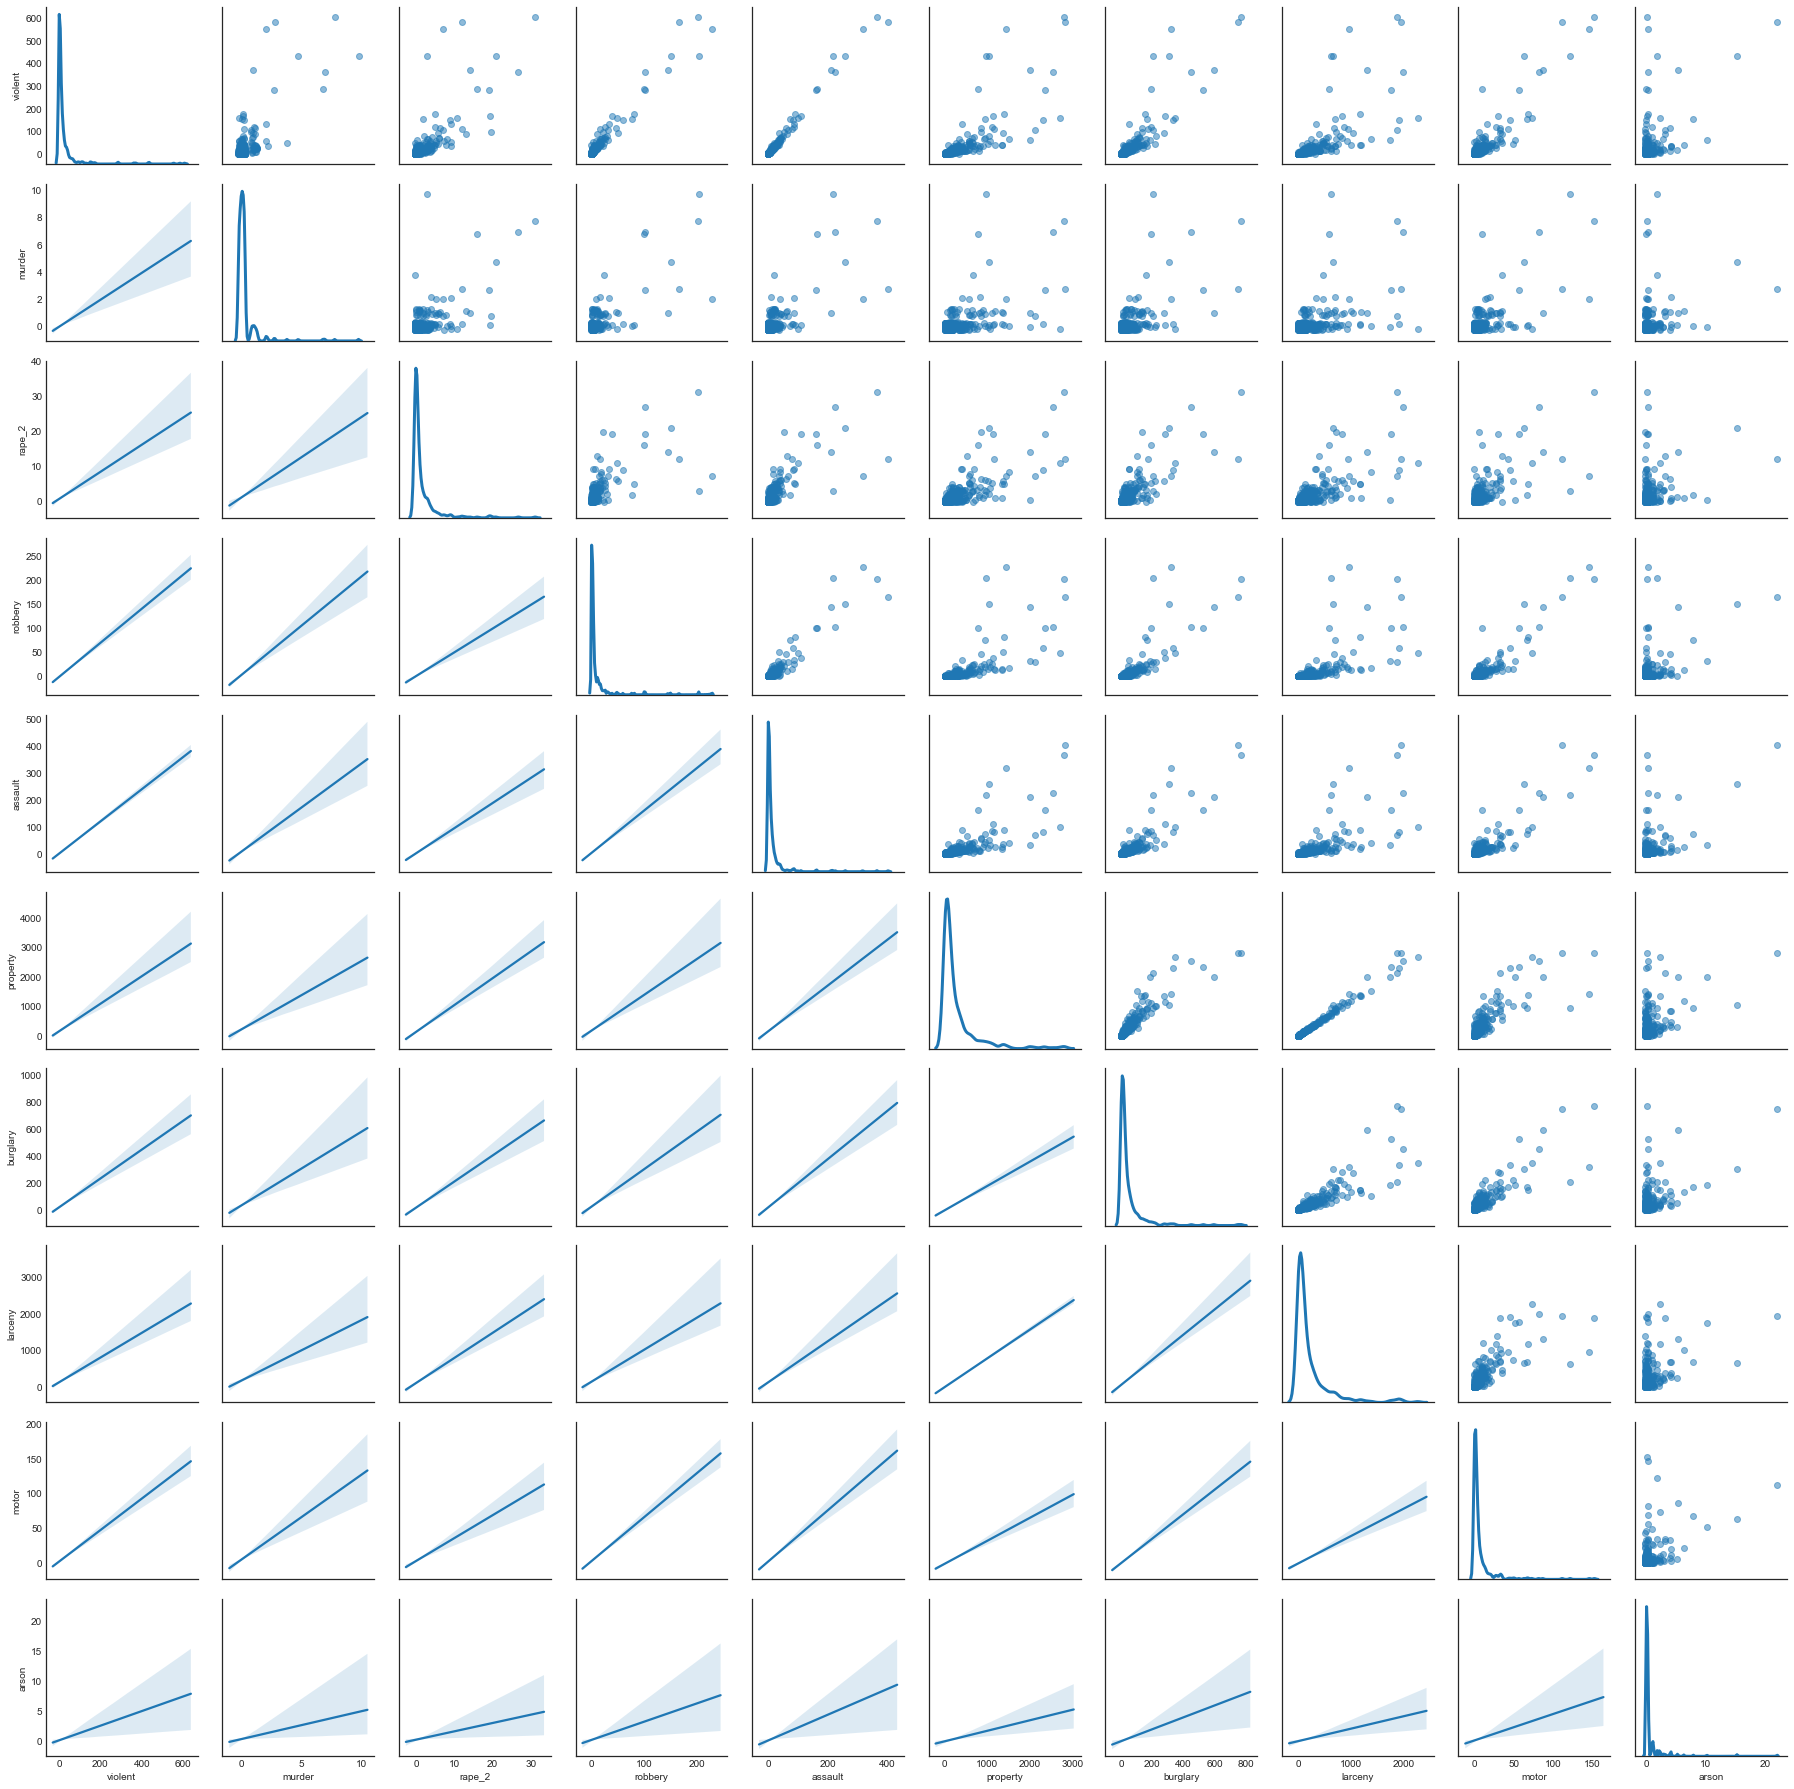

In [449]:
# Make scatterplot matrix
sns.set_style("white")

# Make a copy of the data to add jitter to and plot.\
# Get rid of blanks
df_jittered = df.loc[:, 'violent':'arson'].dropna()
#print(df_jittered)

# Make random noise
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(df_jittered.shape)),
    columns=df_jittered.columns
)
# Combine the data and the noise.
df_jittered = df_jittered.add(jitter)

# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(df_jittered.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

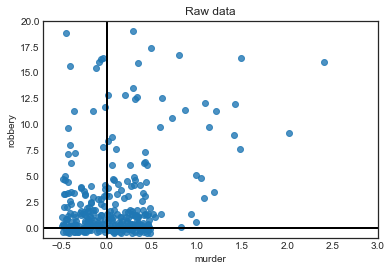

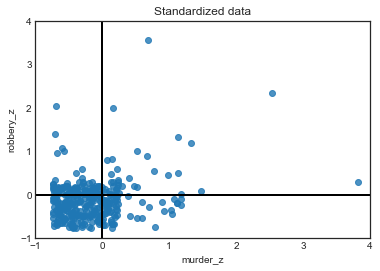

In [450]:
t = sns.regplot(
    'murder',
    'robbery',
    df,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
t.set(xlim=(-0.7, 3), ylim=(-1, 20))
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Raw data')
plt.show()

# Standardizing variables by subtracting the mean and dividing by the standard
# deviation. Now both variables are on the same scale.
df['murder_z'] = (df['murder'] - df['murder'].mean()) / df['murder'].std()
df['robbery_z'] = (df['robbery'] - df['robbery'].mean()) / df['robbery'].std()

t = sns.regplot(
    'murder_z',
    'robbery_z',
    df,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
t.set(xlim=(-1, 4), ylim=(-1, 4))
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Standardized data')
plt.show()

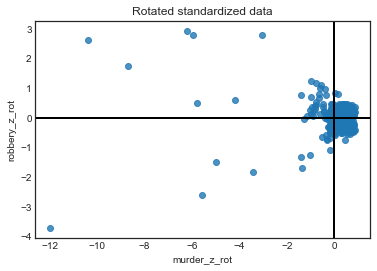

In [451]:
# Rotating the data so that the axes roughly match to vector above.
df['murder_z_rot'] = math.cos(40) * df['murder_z'] - math.sin(40) * df['robbery_z']
df['robbery_z_rot'] = math.sin(40) * df['murder_z'] + math.cos(40) * df['robbery_z']

t = sns.regplot(
    'murder_z_rot',
    'robbery_z_rot',
    df,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Rotated standardized data')
plt.show()

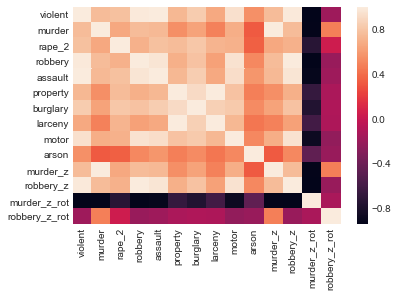

In [452]:
# Plot heatmap of the dataframe
sns.heatmap(df.corr())
plt.show()

# Apply Linear Regression

In [453]:
# Instantiate linear regression
regr = linear_model.LinearRegression()
Y = df['murder']
X = df
regr.fit(X, Y)
                    
# Check the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 8.19133602e-02  3.27512658e-01 -8.19133602e-02 -8.17725772e-02
 -8.19133602e-02 -1.90819582e-15  2.04003481e-15  2.10942375e-15
  1.77635684e-15 -3.19189120e-16  3.10982680e-01 -2.39918578e-03
 -2.05618521e-01  2.33317396e-01]

Intercept: 
 0.15703666697668578

R-squared:
1.0


In [454]:
# Instantiate linear regression
regr = linear_model.LinearRegression()
Y = df['murder']
X = df.drop(['larceny','property', 'murder', 'robbery', 'rape_2','motor','assault'],axis=1)
regr.fit(X, Y)
                    
# Check the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 2.59403956e-17  3.03002401e-18 -1.42177350e-15  5.26577007e-01
 -5.09299196e-16 -3.51194248e-01  3.92359458e-01]

Intercept: 
 0.26822157434402305

R-squared:
1.0


In [455]:
# Instantiate linear regression
regr = linear_model.LinearRegression()
Y = df['murder']
X = df.drop(['larceny','property', 'rape_2','motor'],axis=1)
regr.fit(X, Y)
                    
# Check the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 1.27271811e-15  3.56733933e-01 -1.31780202e-15 -1.54260627e-15
  1.32777073e-17 -1.57728757e-15  3.38729120e-01 -6.62960827e-18
 -2.25911343e-01  2.52391525e-01]

Intercept: 
 0.17253783724501273

R-squared:
1.0


In [456]:
# Instantiate linear regression
regr = linear_model.LinearRegression()
Y = df['murder']
X = df.drop(['larceny','murder', 'rape_2','motor','assault','murder_z','robbery_z','murder_z_rot','robbery_z_rot'],axis=1)
#X = df.drop(['larceny','murder', 'rape_2','motor','assault','murder_z','robbery_z'],axis=1)
regr.fit(X, Y)
                    
# Check the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 0.00710465  0.00512562 -0.00024742  0.00176185 -0.07595642]

Intercept: 
 0.02584089456081623

R-squared:
0.5963794424185671


We choose the last linear regression calculation where the coefficients, intercept, and R-squared is given.  We find that there is an acceptable correlation squared for Murder and Robbery when compared to a variety of data.  The last linear regression compares the murder to the dataset where some columns of data are dropped.

# Applying PCA

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.71364036 0.13227772]


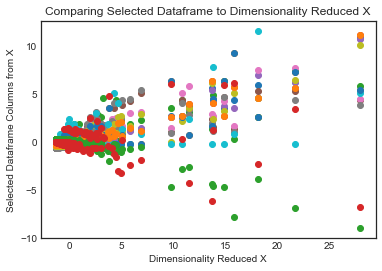

In [457]:
# X is the scalar of the df data.  Standardize features by removing the mean and scaling to unit variance.
# Dataset might behave badly if the individual feature do no look like standard distributed data.
X = StandardScaler().fit_transform(df)
#Y = df['murder']

# Prepare the X and Y variable, where Y is dataframe column.
# fit_transform fits the model with X and apply dimensionality reduction on X.
sklearn_pca = PCA(n_components=2)
X_sklearn = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# Compare the sklearn solution to ours – a perfect match.
plt.plot(X_sklearn[:, 0], X, 'o')
plt.title('Comparing Selected Dataframe to Dimensionality Reduced X')
plt.ylabel('Selected Dataframe Columns from X')
plt.xlabel('Dimensionality Reduced X')
plt.show()

We can see that most of the data is clustered near the upper left corner, meaning that the calculation we did by hand matches the sklearn more closely in the lower values.

# Apply Linear Regression Again

In [458]:
# Instantiate linear regression
regr = linear_model.LinearRegression()
regr.fit(X, Y)
                    
# Check the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 3.30005536e-02  2.77128484e-01 -1.41474424e-03  1.13270049e-01
 -1.97297285e-02 -1.11022302e-16 -1.87566976e-17 -1.66533454e-16
  1.38777878e-17  1.52655666e-16  2.77128484e-01  1.13270049e-01
 -2.03359551e-01  2.63319589e-01]

Intercept: 
 0.26822157434402333

R-squared:
1.0


# Holdout Groups and Cross Validation
Below, we want to change variables so any values greater than 0 is coded as 1.  Also, any values equal to 0 are coded as 0. This needs to be applied to all categories that we have available.  

Holdout Groups is where we select a few of the data for testing only.  This will allow us to evaluate whether our data is overfitting or not.  We want to avoid having out model complex to the point that it starts to catch random noises.  Cross Validation is similar to Holdout Groups, but depends on a different method to operate.  Instead of creating just a single holdout, several holdouts are created

In [459]:
#print(df.loc[df['murder'] > 0])
#df['robbery'].replace(to_replace=df.loc[df['robbery'] > 0], value='1', inplace=True)
#df['robbery'] = df['robbery'].map({227: 1, 0: 0})
df['violent'][df['violent'] > 0] = 1
df['murder'][df['murder'] > 0] = 1
df['rape_2'][df['rape_2'] > 0] = 1
df['robbery'][df['robbery'] > 0] = 1
df['assault'][df['assault'] > 0] = 1
df['property'][df['property'] > 0] = 1
df['burglary'][df['burglary'] > 0] = 1
df['larceny'][df['larceny'] > 0] = 1
df['motor'][df['motor'] > 0] = 1
df['arson'][df['arson'] > 0] = 1
df.head()

C:\Users\nyejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\nyejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\nyejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\nyejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is t

,violent,murder,rape_2,robbery,assault,property,burglary,larceny,motor,arson,murder_z,robbery_z,murder_z_rot,robbery_z_rot
212,0,0,0,0,0,0,0,0,0,0,-0.254684,-0.285100,0.382290,0.000376
260,0,0,0,0,0,0,0,0,0,0,-0.254684,-0.285100,0.382290,0.000376
291,0,0,0,0,0,0,0,0,0,0,-0.254684,-0.285100,0.382290,0.000376
323,0,0,0,0,0,0,0,0,0,0,-0.254684,-0.285100,0.382290,0.000376
299,0,0,0,0,0,0,0,0,0,0,-0.254684,-0.285100,0.382290,0.000376


Here we put down more data to compare, making about 6 out of 14 categories.  Rape, property, burglary, larceny, motor, and arson seem to be lead to murder. The below scores are consistent and shows that we are not overfitting for just the Holdout Group.  

However, the array of 10 folds showed that we have a pretty consistent percentage ranging anywhere from the mid 70% to mid 90%.  This series of accuracy scores represent different holdout groups for each time.  Because they are fluctuating, we can say that they are overfitting.  We need to try a different training set.

In [460]:
data = df[['rape_2', 'property', 'burglary', 'larceny', 'motor', 'arson']]
target = df['murder']

from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
y_pred = bnb.fit(data, target).predict(data)

# Test your model with different holdout groups.
from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
print('With 40% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

# Cross Validation
from sklearn.model_selection import cross_val_score
cross_val_score(bnb, data, target, cv=10)

With 40% Holdout: 0.8260869565217391
Testing on Sample: 0.8542274052478134


array([0.85714286, 0.85714286, 0.94285714, 0.85714286, 0.88235294,
       0.94117647, 0.88235294, 0.76470588, 0.76470588, 0.78787879])

Here we see if murder and robbery include assault, which means 2 out of 14 categories are selected. The below scores are consistent and shows that we are not overfitting.  However, the cross validation looks too normal with all the 80% accuracy rate.  Maybe try another set.

In [461]:
# Simply do not include all of the data in the training set.
data = df[['murder', 'robbery']]
target = df['assault']

from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
y_pred = bnb.fit(data, target).predict(data)

# Test your model with different holdout groups.
from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
print('With 14% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

# Cross Validation
from sklearn.model_selection import cross_val_score
cross_val_score(bnb, data, target, cv=10)

With 14% Holdout: 0.7536231884057971
Testing on Sample: 0.8075801749271136


array([0.8       , 0.8       , 0.8       , 0.8       , 0.8       ,
       0.8       , 0.82352941, 0.81818182, 0.81818182, 0.81818182])

Here we see if murder and robbery are related to violent category, which means 2 out of 14 categories are selected.  The below scores are consistent and shows that we are not overfitting.  This is a pretty good model to work with.

In [462]:
data = df[['murder', 'robbery']]
target = df['violent']

from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
y_pred = bnb.fit(data, target).predict(data)

# Test your model with different holdout groups.
from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
print('With 14% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

# Cross Validation
from sklearn.model_selection import cross_val_score
cross_val_score(bnb, data, target, cv=10)

With 14% Holdout: 0.8405797101449275
Testing on Sample: 0.8513119533527697


array([0.83333333, 0.85714286, 0.85294118, 0.85294118, 0.85294118,
       0.85294118, 0.85294118, 0.85294118, 0.85294118, 0.85294118])

# Apply Residual

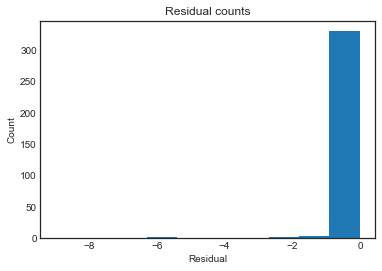

In [463]:
#### Extract predicted values.
predicted = regr.predict(X).ravel()
#actual = df['murder']
actual = Y

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()